In [21]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from sklearn import datasets

# from deep_nn_utilities import *

In [125]:
def initialize_parameters(layer_dims):
# layers_dims: array containing dimensions of each layer ex initialize_parameters([5, 4, 3])

    np.random.seed(3)
    parameters = {}
    L = len(layer_dims) # number of layers in nn
    
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l-1], layer_dims[l]) * 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l-1], layer_dims[l]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))
#     print([(k, parameters[k].shape) for k, v in parameters.items()])
    return parameters

def linear_forward(A, W, b):
#     print('\nlinear forward')
#     print('W', W.shape, 'A', A.shape)
    Z = np.dot(W.T, A) + b
    
#     print('Z', Z.shape)
    
    assert(Z.shape == (W.shape[1], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

def sigmoid(Z):
    A = 1 / (1 + np.exp(-Z))
    cache = Z
    return A, cache

def relu(Z):
    A = np.maximum(0, Z)
    
    assert(A.shape == Z.shape)
    cache = Z
    return A, cache

def softmax(Z):
    t = np.exp(Z)
    A = t / np.sum(t, axis=0)
    cache = Z

    return A, cache
    

def neuron_activation(A_prev, W, b, activation):
    if activation == 'sigmoid':
        Z, linear_cache = linear_forward(A_prev, W, b)
        # linear cache: A, W, b
        A, activation_cache = sigmoid(Z)
        # activation cache: Z
        
    elif activation == 'relu':
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
        
    elif activation == 'softmax':
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = softmax(Z)
        
    assert (A.shape == (W.shape[1], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)
    
    return A, cache

def L_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2 # // is floor division
    
    for l in range(1, L):
        
        A_prev = A
        
        A, cache = neuron_activation(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], 'relu')
        caches.append(cache)

    AL, cache = neuron_activation(A, parameters['W' + str(L)], parameters['b' + str(L)], 'softmax')
    caches.append(cache)
#     print('\n', AL)
#     assert(AL.shape == (1, X.shape[1]))
#     assert(AL.shape == (3, X.shape[1])) # should be  (classes x m)

    return AL, caches

def compute_cost(AL, Y):
    m = Y.shape[1]
    
#     cost = (-1/m) * np.sum(Y*np.log(AL) + (1-Y)*np.log(1-AL))
    
#     cost = np.squeeze(cost)
#     assert(cost.shape == ())

    cost = (-1/m) * np.sum(Y * np.log(AL))
    
    return cost
    
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]
#     print('dZ.shape', dZ.shape, 'A_prev.shape', A_prev.shape, 'W.shape', W.shape)
#     dW = (1/m) * np.dot(dZ, A_prev.T)
    dW = (1/m) * np.dot(A_prev, dZ.T)
    db = (1/m) * np.sum(dZ, axis=1, keepdims=True)
#     dA_prev = np.dot(W.T, dZ)
    dA_prev = np.dot(W, dZ)
    
#     assert (dA_prev.shape == A_prev.shape)
#     assert (dW.shape == W.shape)
#     assert (db.shape == b.shape)
    
    return dA_prev, dW, db

def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True)
    
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

def sigmoid_backward(dA, cache):
    Z = cache
    s = 1 / (1 + np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ

def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache
    # check here for reverse grad shape bug
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
       
    elif activation == 'softmax':
        dZ = dA
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    return dA_prev, dW, db

def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches)
    m = AL.shape[1]
#     Y = Y.reshape(AL.shape)
    
#     dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL)) #derivative of cost function
    dAL = AL - Y
#     print('dAL.shape', dAL.shape)
    current_cache = caches[L-1]
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, "softmax")
    
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l+2)], current_cache, "relu")
        grads["dA" + str(l+1)] = dA_prev_temp
        grads["dW" + str(l+1)] = dW_temp
        grads["db" + str(l+1)] = db_temp
            
    return grads

def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2      
#     print('\nupdate parameters')                               
#     print([(k, parameters[k].shape) for k, v in parameters.items()])
#     print('grads')
#     print([(k, grads[k].shape) for k, v in grads.items()])
    for l in range(1, L+1):
        parameters['W'+str(l)] = parameters['W'+str(l)] - learning_rate * grads['dW'+str(l)]
        parameters['b'+str(l)] = parameters['b'+str(l)] - learning_rate * grads['db'+str(l)]
        
    return parameters

def predict(X, y, parameters):
    print('I predict...')
    print('X', X.shape, 'Y.shape', Y.shape)
    m = X.shape[1]
    n = len(parameters) // 2
    p = np.zeros((y.shape[0], m))
    acc = []
    probas, caches = L_model_forward(X, parameters)
    print('probas\n', probas.shape)
    # max for each example
    # search for index == max
    # assign 1 to that class and 0 to the others
    for i in range(0, probas.shape[1]):
        print(probas[:, i])
        index = np.where(probas[:, i] == np.max(probas[:, i]))
        probas[index, i] = 1
        zeros = np.where(probas[:, i] != 1)
        probas[zeros, i] = 0
        if np.where(probas[:,i] == 1) == np.where(y[:,i] ==1):
            acc.append(True)
#         print(probas[:, i], 'probas')
#         print(y[:, i], 'y')
#         print(np.where(probas[:,i] == 1) == np.where(y[:,i] ==1))
#         probas[:, i][probas != 1] = 0
#         print(index)
#         print(np.max(probas[:,i]))
#         if probas[0, i] > 0.5:
#             p[0, i] = 1
#         else:
#             p[0, i] = 0
    print(type(probas))
    print("Accuracy: " + str(sum(acc)/m))
#     print("Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p

In [126]:
def L_layer_model(X, Y, layer_dims, learning_rate = .0075, num_iterations = 10, print_cost = False):
    np.random.seed(1)
    costs = []
    
    parameters = initialize_parameters(layer_dims)
    for i in range(0, num_iterations):
        AL, caches = L_model_forward(X, parameters)
        
        cost = compute_cost(AL, Y)
        grads = L_model_backward(AL, Y, caches)
        
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # Print the cost every 100 training example
        if print_cost and i % 10000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 10000 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

In [127]:
iris = datasets.load_iris(True)
iris[0].shape[0]
X = iris[0].T
# X = X[:, :5]
Y_cat = iris[1]
Y = []
for i in Y_cat:
    if i==0:
        Y.append([1,0,0])
    elif i == 1:
        Y.append([0,1,0])
    elif i == 2:
        Y.append([0,0,1])
Y = np.array(Y).T
# split into training/test
# Y = Y[:, :5]
# print('X.shape', X.shape)
# print('Y.shape', Y.shape)


In [128]:
# create dummy data in three distinct categories of magnitude, X: [3,30]
inputs = X.shape[0]
m = X.shape[1]
layer_dims = [inputs, 3, 4, 5, 3]
# sm = np.random.rand(inputs, m) * -10000
# md = np.random.rand(inputs, m) * 1
# lg = np.random.rand(inputs, m) * 10000
# X = np.hstack((sm, md, lg))

# cat1_truth = np.array([[1], [0], [0]]) 
# cat2_truth = np.array([[0], [1], [0]])
# cat3_truth = np.array([[0], [0], [1]])
# Y = np.array([[1], [0], [0]])

# # Y: [3, 30] for soft max
# for i in range(1, X.shape[1]):
#     if i < X.shape[1]/3:
#         Y = np.hstack((Y, cat1_truth))
#     elif i < X.shape[1] * (2/3):
#         Y = np.hstack((Y, cat2_truth))
#     elif i < X.shape[1]:
#         Y = np.hstack((Y, cat3_truth))
print('X.shape', X.shape)
print('Y.shape', Y.shape)

X.shape (4, 150)
Y.shape (3, 150)


Cost after iteration 0: 1.098612
Cost after iteration 10000: 1.098612
Cost after iteration 20000: 1.098612
Cost after iteration 30000: 1.098609
Cost after iteration 40000: 0.050234
Cost after iteration 50000: 0.045491
Cost after iteration 60000: 0.042319
Cost after iteration 70000: 0.040137
Cost after iteration 80000: 0.039944
Cost after iteration 90000: 0.039792
Cost after iteration 100000: 0.039736


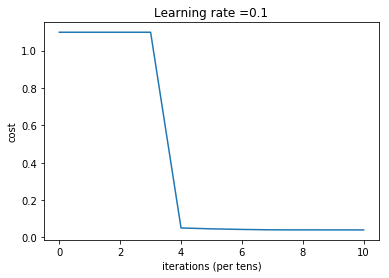

In [129]:
parameters = L_layer_model(X, Y, layer_dims, .1, 110000, True)
# cost <= 6.794738

In [130]:
p = predict(X, Y, parameters)
print('p.shape', p.shape)

I predict...
X (4, 150) Y.shape (3, 150)
probas
 (3, 150)
[9.99999381e-01 6.18525851e-07 1.49733993e-38]
[9.99995399e-01 4.60103659e-06 3.62712362e-34]
[9.99997861e-01 2.13912244e-06 7.69573119e-36]
[9.99990459e-01 9.54110914e-06 1.42235360e-32]
[9.99999461e-01 5.38948485e-07 7.48913594e-39]
[9.99999190e-01 8.09789538e-07 5.80742198e-38]
[9.99996933e-01 3.06681552e-06 4.71316876e-35]
[9.99998311e-01 1.68936690e-06 2.34717117e-36]
[9.99983657e-01 1.63429163e-05 2.13228877e-31]
[9.99996115e-01 3.88521683e-06 1.54919159e-34]
[9.99999701e-01 2.99120578e-07 3.87328222e-40]
[9.99995980e-01 4.02048943e-06 1.84026278e-34]
[9.99996021e-01 3.97907497e-06 1.74685858e-34]
[9.99997658e-01 2.34246751e-06 1.21520695e-35]
[9.99999988e-01 1.21609804e-08 3.89946297e-47]
[9.99999966e-01 3.38138944e-08 6.68756281e-45]
[9.99999886e-01 1.13860499e-07 3.00496462e-42]
[9.99999137e-01 8.63395220e-07 8.01724555e-38]
[9.99999543e-01 4.56851386e-07 3.26112443e-39]
[9.99999470e-01 5.30204684e-07 6.89755560e-39]
[9